# Image Classification PyTorch 01

Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

The data is balance:
- Train 4000 cats and 4000 dogs
- Test 1000 cats and 1000 dogs

Using simple 1 Conv2d and 1 Linear

Import function

In [18]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
TRAIN_FOLDER = '~/data1/data/mlzoomcamp25/catdog/train'
TEST_FOLDER = '~/data1/data/mlzoomcamp25/catdog/test'

SEED = 42
BATCH_SIZE = 20
IMAGE_SIZE = 150
EPOCHS = 10

Set random seed

In [20]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



Set divice to 'cuda' if available, otherwise 'cpu'

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Create 2 transforms, one for train, one for val/test

The transforms will do:
- Resize
- Convert to Tensor
- Normalize image

Use separate transforms for train and test/val, because in train transforms, it can be added augmentation.
For test/val, no augmentation, just resize + tensor + normalize. 

In [22]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


Create train and test dataset. All images put in separate folders (train and test folder).

In [23]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_FOLDER,  transform=test_val_transform)

# verify the number of classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


Create train and test DataLoader.

The data will be shuffled with parameter shuffle. For test/val loader, no need to shuffle.

batch_size is number of images in one batch.

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                          )

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                         )


Create class model by extends nn.Module.

The class model minimal have function:
- __init__
  In this function, declare the model layers like Conv2d, Relu, Linear etc
- forward
  In forward function, it has parameter input image as array.
  Construct layers as complete model.
  The image array is in format 4-dim Tensor with shape [B, C, H, W]. Where B is batch, C is channels (RGB), H is height and W is width.


Model layers:
- Conv2d 32, kernel 3, stride 1, padding 0
  ```
  Hout​=(Input+2Padding−Kernel​)/Stride+1
  ```
  output = (150 + 2*0 - 3)/1 + 1 = 148
  Shape: (32, 148, 148)
- Relu, output same 148.
  Shape: (32, 148, 148)
- MaxPool2d, output become half, 74
  Shape: (32, 74, 74)
- Flatten. Output flatten = 32 × 74 × 74 = 175,232
- 1 level Linear. output 1 (binary classification)

  

In [25]:
# create model
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()

        # Hout​=(Input+2Padding−Kernel​)/Stride+1
        self.base_model = nn.Sequential(
            # (150 + 2*0 - 3)/1 + 1 = 148
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), # (32, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (32, 74, 74)
        )
        self.flatten = nn.Flatten() # (32, 74*74,) = 175232
        self.fc = nn.Sequential(
            nn.Linear(32 * 74 * 74, 1), # (1,)
        )
               

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x 

- Sets the model to training mode.
- Iterates item in batches in the data loader.
- For each batch:
  - Moves images and labels to the device (CPU/GPU).
  - Ensures labels are the correct shape and type.
  - Clears previous gradients.
  - Performs a forward pass to get model outputs.
  - Computes the loss between outputs and labels.
  - Backpropagates the loss and updates model weights.
  - Tracks total loss and number of correct predictions.
- Calculates average loss and accuracy for the epoch.
- Returns the average loss and accuracy.

In [26]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.float()
        if labels.ndim == 1:
            labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


The validate function evaluates the model on a validation dataset without updating model weights.

- Sets the model to eval mode.
- Disable gradient computation (torch.no_grad()).
- Iterates over batches from test DataLoader.
- For each batch:
  - Moves images and labels to the device (CPU/GPU).
  - Ensures labels are the correct shape and type.
  - Do forward pass to get model outputs.
  - Computes the loss between outputs and labels.
  - Convert output to binary classification, using sigmoid.
  - Calculate total loss and number of correct predictions.
- Calculates average loss and accuracy for the epoch.
- Returns the average loss and accuracy.

In [27]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float()
            if labels.ndim == 1:
                labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


- Initialize model.
- Set model to device (CPU/GPU).
- Use BCEWithLogitsLoss for binary classification.
- use SGD for optimizer.

In [28]:

model = CatDogModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4)

Training loop

In [29]:

arr_train_acc = []
arr_train_loss = []

arr_test_acc = []
arr_test_loss = []

idx = 0
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = validate(model, test_loader, criterion)

    arr_train_acc.append(train_acc)
    arr_train_loss.append(train_loss)
    arr_test_acc.append(test_acc)
    arr_test_loss.append(test_loss)

    print(idx)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {test_loss:.4f} | Val Acc: {test_acc:.4f}")

    idx += 1


0
Epoch 1/10
  Train Loss: 0.6710 | Train Acc: 0.5818
  Val Loss  : 0.6817 | Val Acc: 0.6045
1
Epoch 2/10
  Train Loss: 0.6413 | Train Acc: 0.6249
  Val Loss  : 0.6326 | Val Acc: 0.6347
2
Epoch 3/10
  Train Loss: 0.6221 | Train Acc: 0.6513
  Val Loss  : 0.6419 | Val Acc: 0.6307
3
Epoch 4/10
  Train Loss: 0.6104 | Train Acc: 0.6618
  Val Loss  : 0.6474 | Val Acc: 0.6362
4
Epoch 5/10
  Train Loss: 0.6009 | Train Acc: 0.6740
  Val Loss  : 0.6470 | Val Acc: 0.6288
5
Epoch 6/10
  Train Loss: 0.5902 | Train Acc: 0.6826
  Val Loss  : 0.6301 | Val Acc: 0.6396
6
Epoch 7/10
  Train Loss: 0.5817 | Train Acc: 0.6897
  Val Loss  : 0.6425 | Val Acc: 0.6268
7
Epoch 8/10
  Train Loss: 0.5762 | Train Acc: 0.6996
  Val Loss  : 0.7277 | Val Acc: 0.5645
8
Epoch 9/10
  Train Loss: 0.5702 | Train Acc: 0.7043
  Val Loss  : 0.6342 | Val Acc: 0.6555
9
Epoch 10/10
  Train Loss: 0.5617 | Train Acc: 0.7118
  Val Loss  : 0.6198 | Val Acc: 0.6698


Plot the result

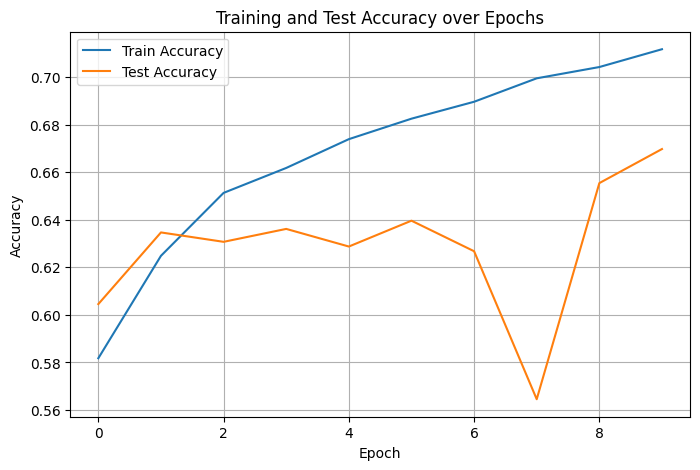

In [30]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_acc, label='Train Accuracy')
plt.plot(arr_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

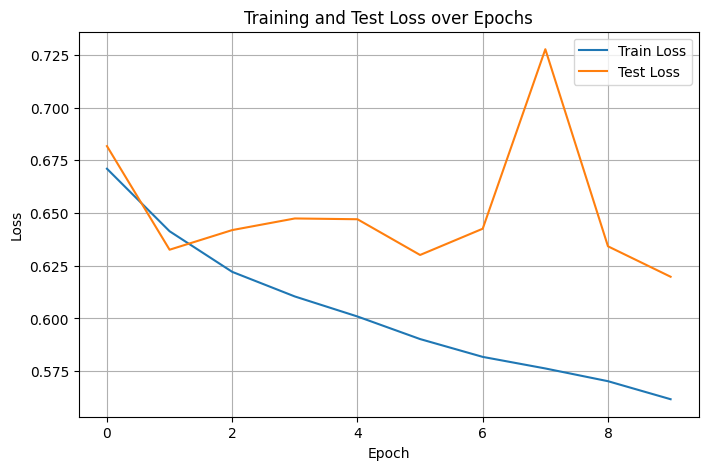

In [31]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_loss, label='Train Loss')
plt.plot(arr_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:

df_train = pd.DataFrame({
    'train_loss': arr_train_loss,
    'train_accuracy': arr_train_acc
})
df_train

,train_loss,train_accuracy
0,0.670996,0.581761
1,0.641338,0.624859
2,0.622077,0.651343
3,0.610398,0.661836
4,0.600900,0.673954
5,0.590195,0.682573
6,0.581741,0.689694
7,0.576249,0.699563
8,0.570209,0.704310
9,0.561657,0.711805
